# Interacting with ProtoDash

In this notebook we'll combine the ProtoDash and the Partial Effects to obtain feature importances on the digits classifications task.

ProtoDash was proposed in _Gurumoorthy, Karthik & Dhurandhar, Amit & Cecchi, Guillermo & Aggarwal, Charu. (2019). Efficient Data Representation by Selecting Prototypes with Importance Weights. 260-269. 10.1109/ICDM.2019.00036_.

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp # v0.2.13

import shap #0.34.0

from sklearn.metrics import classification_report
from sklearn         import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

from sklearn.preprocessing import OneHotEncoder

from aix360.algorithms.protodash import ProtodashExplainer #0.2.1

import warnings
warnings.filterwarnings(action='ignore', module=r'itea')

In [2]:
digits_data = datasets.load_digits(n_class=10)

X, y        = digits_data['data'], digits_data['target']
labels      = digits_data['feature_names']
targets     = digits_data['target_names']

X /= X.max(axis=1).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'id' : lambda x: x,
    'sin': jnp.sin,
    'cos': jnp.cos,
    'tan': jnp.tan
}

clf = ITEA_classifier(
    gens            = 100,
    popsize         = 100,
    max_terms       = 40,
    expolim         = (0, 2),
    verbose         = 10,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = None,
    random_state    = 42,
    fit_kw          = {'max_iter' : 5}
).fit(X_train, y_train)

final_itexpr = clf.bestsol_
final_itexpr.selected_features_

gen | smallest fitness | mean fitness | highest fitness | remaining time (s)
----------------------------------------------------------------------------
  0 |         0.103907 |     0.104023 |        0.105569 | 10min6seg   
 10 |         0.105569 |     0.105569 |        0.105569 | 1min11seg   
 20 |         0.105569 |     0.107406 |        0.161264 | 2min43seg   
 30 |         0.161264 |     0.168412 |        0.201164 | 5min13seg   
 40 |         0.234414 |     0.274763 |        0.312552 | 6min22seg   
 50 |         0.325021 |     0.382643 |        0.426434 | 6min7seg    
 60 |         0.426434 |     0.485046 |        0.551122 | 5min12seg   
 70 |         0.551122 |     0.601355 |        0.634248 | 4min25seg   
 80 |         0.632585 |     0.634813 |        0.635910 | 2min54seg   
 90 |         0.637573 |     0.671771 |        0.684954 | 1min16seg   


array(['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4',
       'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1',
       'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6',
       'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3',
       'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0',
       'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5',
       'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2',
       'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7',
       'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4',
       'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1',
       'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6',
       'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3',
       'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7'], dtype='<U9')

In [3]:
print(classification_report(
    y_test,
    final_itexpr.predict(X_test),
    target_names=[str(t) for t in targets]
))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76        55
           1       0.67      0.58      0.62        55
           2       0.48      0.83      0.61        52
           3       0.69      0.61      0.65        56
           4       0.78      0.80      0.79        64
           5       0.69      0.55      0.61        73
           6       0.79      0.88      0.83        57
           7       0.67      0.58      0.62        62
           8       0.50      0.33      0.40        52
           9       0.66      0.71      0.68        68

    accuracy                           0.66       594
   macro avg       0.67      0.67      0.66       594
weighted avg       0.67      0.66      0.66       594



We can use the ``ITEA_summarizer`` to inspect the convergence during the evolution. In the cell below, we'll create 3 plots, one for the fitness (classification accuracy), one for the complexity (number of nodes if the IT expression was converted to a symbolic tree) and number of terms (number of IT terms of the solutions in the population for each generation).

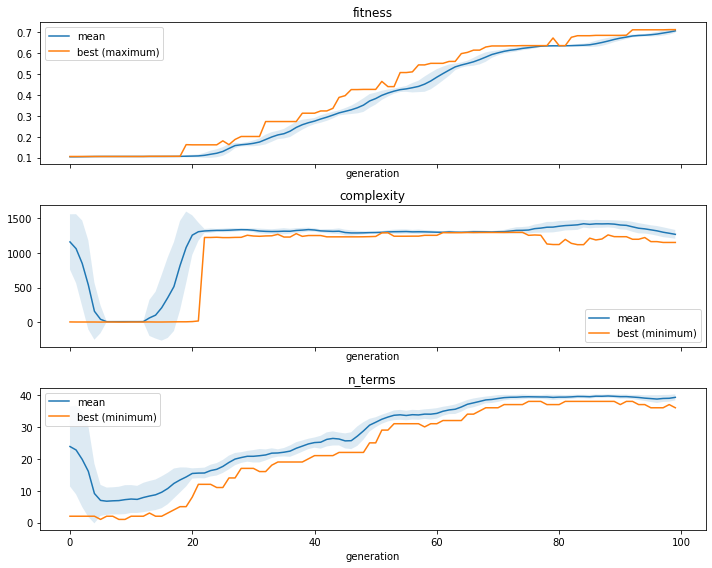

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

summarizer = ITEA_summarizer(itea=clf).fit(X_train, y_train).plot_convergence(
    data=['fitness', 'complexity', 'n_terms'],
    ax=ax,
    show=False
)

plt.tight_layout()
plt.show()

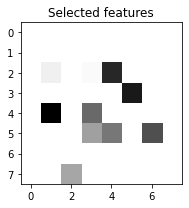

In [5]:
# features are named pixel_x_y. Lets extract those coordinates and
# paint in a figure to show the selected features

selected_features = np.zeros((8, 8))
for feature_name, feature_importance in zip(
    final_itexpr.selected_features_,
    np.sum(final_itexpr.feature_importances_, axis=0)
):
    x, y = feature_name[-3], feature_name[-1]
    selected_features[int(x), int(y)] = feature_importance

fig, axs = plt.subplots(1, 1, figsize=(3,3))

axs.imshow(selected_features, cmap='gray_r')
axs.set_title(f"Selected features")

plt.tight_layout()
plt.show()

In [6]:
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(
    np.hstack( (X_train, y_train.reshape(-1, 1)) ) )

explainer = ProtodashExplainer()

# call protodash explainer. We'll select 10 prototypes
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


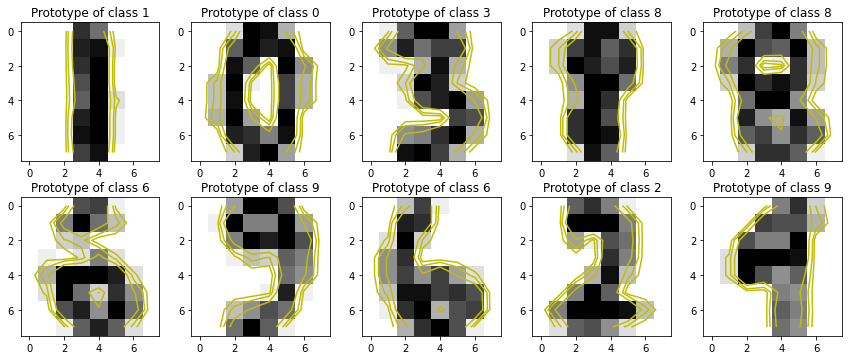

In [7]:
from matplotlib import cm

fig, axs = plt.subplots(2, 5, figsize=(12,5))

# Showing 10 prototypes
for s, ax in zip(S, fig.axes):
    ax.imshow(X_train[s].reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Prototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')


plt.tight_layout()
plt.show()

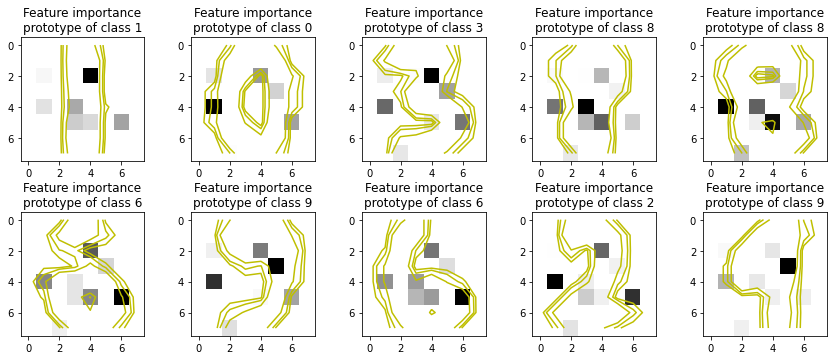

In [8]:
it_explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for s, ax in zip(S, fig.axes):
    
    importances = it_explainer.average_partial_effects(X_train[s, :].reshape(1, -1))[y_train[s]]
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()

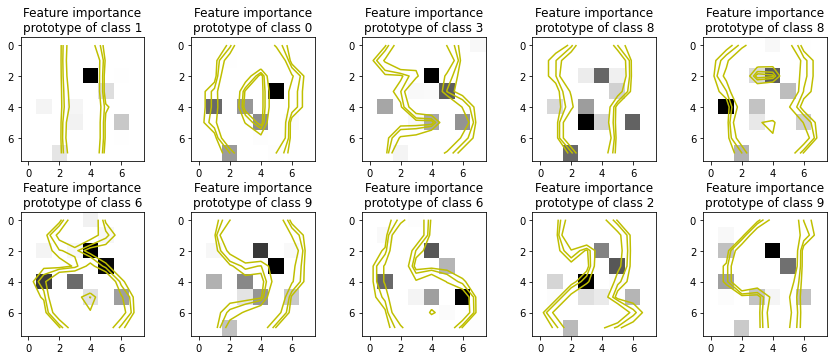

In [11]:
shap_explainer = shap.KernelExplainer(
    final_itexpr.predict,
    shap.sample(pd.DataFrame(X_train, columns=labels), 100)
)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for s, ax in zip(S, fig.axes):
    
    importances = np.abs(shap_explainer.shap_values(
            X_train[s, :].reshape(1, -1), silent=True, l1_reg='num_features(10)'))
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {y_train[s]}")
    
    Z = X_train[s].reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()

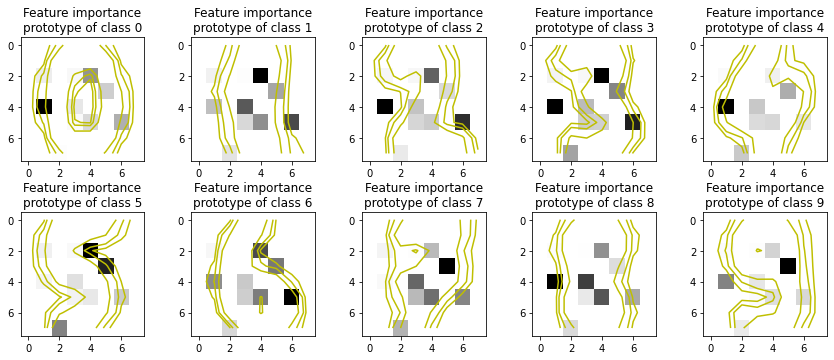

In [10]:
it_explainer = ITExpr_explainer(
    itexpr=final_itexpr,
    tfuncs=tfuncs
).fit(X_train, y_train)

fig, axs = plt.subplots(2, 5, figsize=(12,5))

for c, ax in zip(final_itexpr.classes_, fig.axes):
    
    c_idx = np.array([i for i in range(len(y_train)) if y_train[i]==c])
    
    importances = it_explainer.average_partial_effects(X_train[c_idx, :])[c]
    
    ax.imshow(importances.reshape(8, 8), cmap='gray_r')
    ax.set_title(f"Feature importance\nprototype of class {c}")
    
    Z = X_train[c_idx, :].mean(axis=0).reshape(8, 8)
    levels = [0.1, 0.2, 0.4]

    norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
    cmap = cm.PRGn

    cset2 = ax.contour(Z, levels, colors='y')

    for c in cset2.collections:
        c.set_linestyle('solid')
    
plt.tight_layout()
plt.show()